EDA


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('AAPL.csv')

print(df.head())
print(df.describe())

         Date       Close        High         Low        Open     Volume
0  2020-12-04  119.004539  119.598346  118.293916  119.345246   78260400
1  2020-12-07  120.464729  121.262960  119.004551  119.062956   86712000
2  2020-12-08  121.078011  121.662088  119.822256  121.068281   82225500
3  2020-12-09  118.547028  122.606322  117.787736  121.224022  115089200
4  2020-12-10  119.968254  120.581534  116.960290  117.300997   81312200
             Close         High          Low         Open        Volume
count  1255.000000  1255.000000  1255.000000  1255.000000  1.255000e+03
mean    177.263802   179.021153   175.325123   177.074630  7.080810e+07
std      38.859397    39.090453    38.552158    38.773880  3.019210e+07
min     113.440178   117.378788   113.293940   116.043177  2.013560e+07
25%     145.509323   146.550698   143.662205   145.287021  4.888145e+07
50%     171.182404   172.195331   168.949173   170.671435  6.412650e+07
75%     207.659744   210.463725   205.177185   206.776193 

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

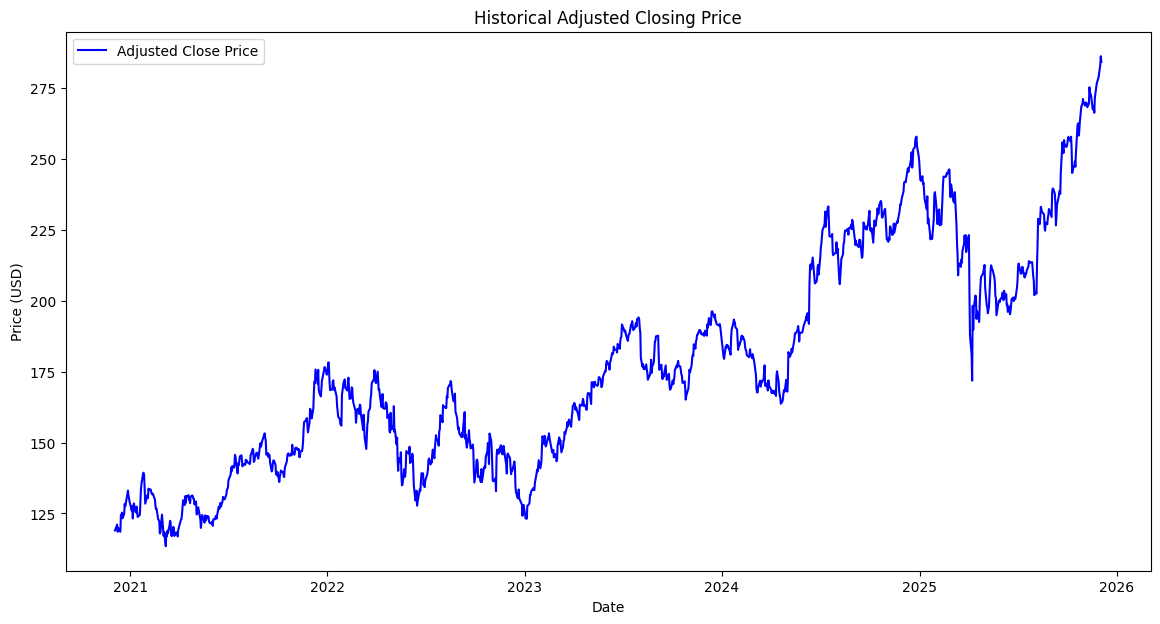

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Adjusted Close Price', color='blue')
plt.title('Historical Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

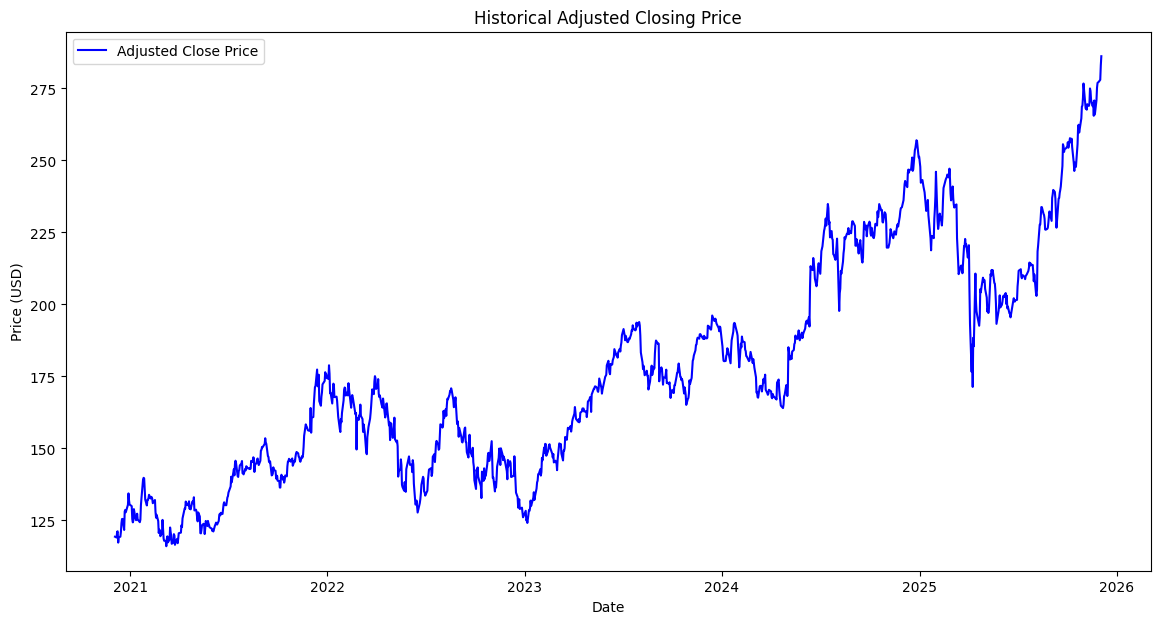

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df['Open'], label='Adjusted Close Price', color='blue')
plt.title('Historical Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

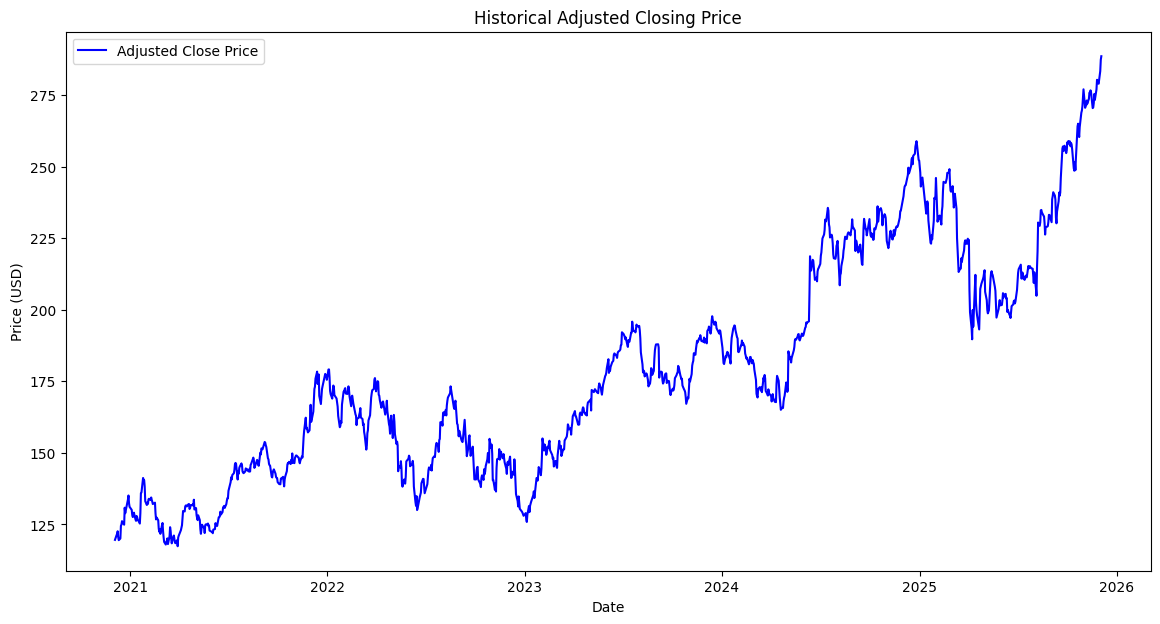

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df['High'], label='Adjusted Close Price', color='blue')
plt.title('Historical Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

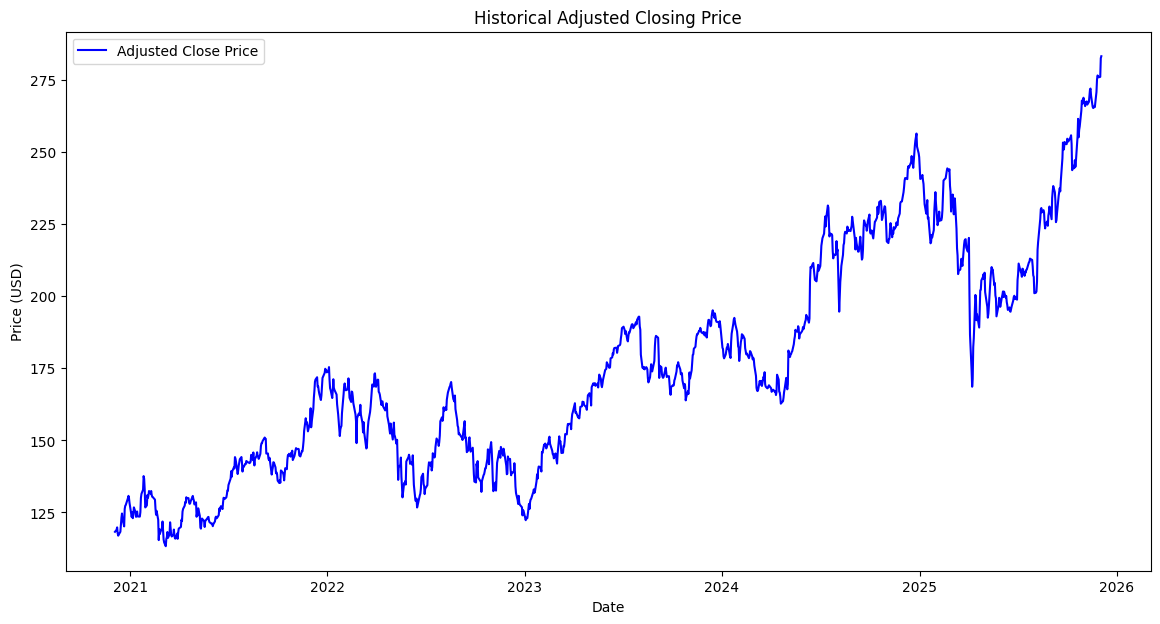

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(df['Low'], label='Adjusted Close Price', color='blue')
plt.title('Historical Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [8]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2020-12-04,119.004539,119.598346,118.293916,119.345246,78260400
2020-12-07,120.464729,121.262960,119.004551,119.062956,86712000
2020-12-08,121.078011,121.662088,119.822256,121.068281,82225500
2020-12-09,118.547028,122.606322,117.787736,121.224022,115089200
2020-12-10,119.968254,120.581534,116.960290,117.300997,81312200


In [9]:
# Summarizes missing values for every column in the dataset
print(df.isnull().sum())

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


Correlation analysis

close vs open

In [10]:
df[['Close','Open']].corr(method='pearson')

,Close,Open
Close,1.000000,0.997779
Open,0.997779,1.000000


In [11]:
df[['Close','High']].corr(method='pearson')

,Close,High
Close,1.000000,0.999025
High,0.999025,1.000000


In [12]:
df[['Close','Low']].corr(method='pearson')

,Close,Low
Close,1.000000,0.998983
Low,0.998983,1.000000


Preprocessing + Feature engineering

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
data = df[['Close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Hàm tạo chuỗi dữ liệu (Sliding Window)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0]) 
        y.append(data[i, 0])            
    return np.array(X), np.array(y)



Training model

sliding_window = 10, epoch = 50, 2 BiLSTM model, batch size = 32

In [39]:
X, y = create_sequences(scaled_data, 10)

# Reshape X để phù hợp đầu vào BiLSTM: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:]   # Dùng làm tập validation (X_val) thay vì X_test để khớp với code model
y_val = y[train_size:]

# 1. Khởi tạo mô hình Sequential
model = Sequential()




# 2. Thêm lớp Bidirectional LSTM
# input_shape=(time_steps, features)
model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Ngăn chặn overfitting 

# Thêm lớp BiLSTM thứ hai để học các đặc trưng sâu hơn
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.2))

# 3. Lớp Dense đầu ra (Dự đoán 1 giá trị duy nhất là giá Close)
model.add(Dense(units=1, activation='linear')) # Activation 'linear' cho bài toán hồi quy 

# 4. Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error') # Sử dụng Adam và MSE [cite: 972, 974]

# 5. Thiết lập Early Stopping để dừng huấn luyện khi mô hình ngừng cải thiện
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# 6. Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=50, # Chạy tối đa 50 vòng lặp
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

h:\Study\CS\C elective\251 Machine Learning\Project\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0105 - val_loss: 0.0031
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

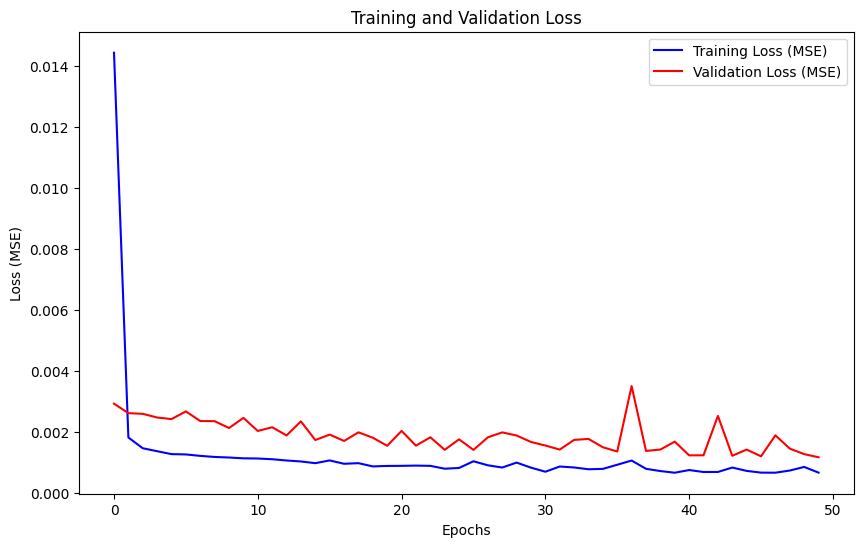

In [ ]:
import matplotlib.pyplot as plt

# Lấy giá trị loss từ biến history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training Loss (MSE)')
plt.plot(epochs, val_loss, 'r', label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [29]:
# 1. Dự đoán trên tập validation (hoặc tập test nếu bạn tách riêng)
predicted_stock_price = model.predict(X_val)

# 2. Đưa giá trị về đơn vị tiền tệ thực tế (Inverse Transform)
# Lưu ý: scaler đã fit với dữ liệu gốc ban đầu
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_val.reshape(-1, 1))

print("Dự đoán mẫu:", predicted_stock_price[:5])
print("Giá thực tế mẫu:", real_stock_price[:5])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Dự đoán mẫu: [[240.71143]
 [241.70334]
 [242.13905]
 [243.70856]
 [245.1338 ]]
Giá thực tế mẫu: [[241.94572449]
 [241.74662781]
 [245.63902283]
 [246.65444946]
 [245.38021851]]


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Tính toán các chỉ số
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = math.sqrt(mse)
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)

print(f"RMSE (Sai số chuẩn): {rmse}")
print(f"MAE (Sai số tuyệt đối): {mae}")
print(f"R² Score (Độ phù hợp): {r2}")

RMSE (Sai số chuẩn): 5.907832830054022
MAE (Sai số tuyệt đối): 4.162613589122112
R² Score (Độ phù hợp): 0.940398331967413


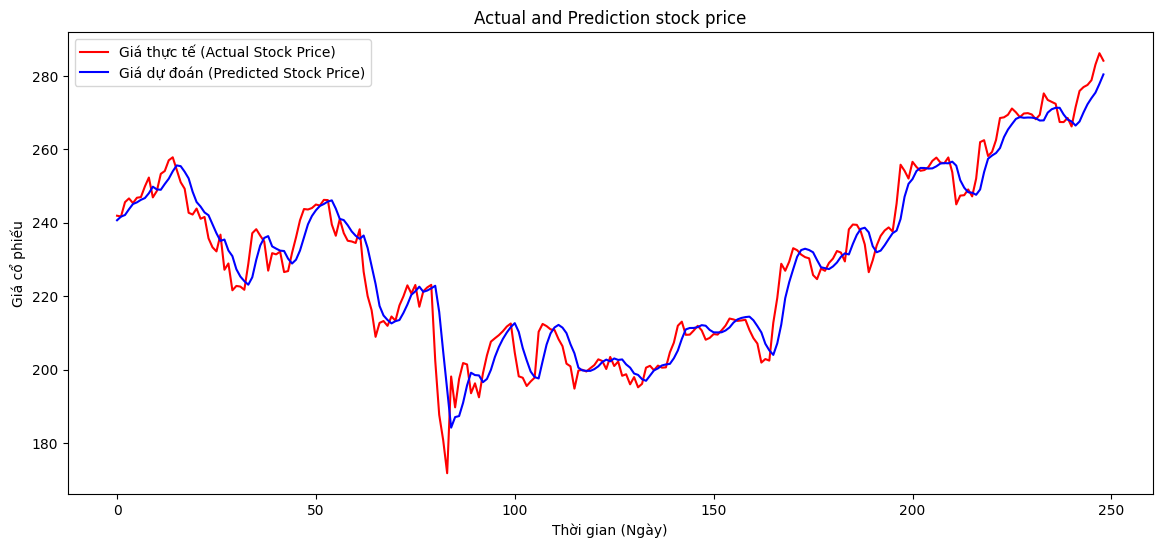

In [33]:
plt.figure(figsize=(14, 6))
plt.plot(real_stock_price, color='red', label='Giá thực tế (Actual Stock Price)')
plt.plot(predicted_stock_price, color='blue', label='Giá dự đoán (Predicted Stock Price)')
plt.title('Actual and Prediction stock price')
plt.xlabel('Thời gian (Ngày)')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()

In [47]:
percentage_difference = np.abs(predicted_stock_price / real_stock_price - 1)
average_percentage = np.mean(percentage_difference) * 100
print(f"The average percentage is: {average_percentage}%")

The average percentage is: 2.315422211804767%
